In [1]:
import warnings
from datetime import date
import json

import matplotlib.pyplot as plt
import seaborn as sns
import pandas
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tools.sm_exceptions import ValueWarning
from sklearn.utils import resample

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (25, 15)})
sns.set(font_scale=2)
sns.set_style("ticks")

warnings.simplefilter("ignore", FutureWarning)  # ignore some seaborn warnings until they update numpy
# silence statsmodels warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", ValueWarning)

In [2]:
df = pandas.read_csv("NHL_API_point_totals_by_team_season_raw_1996-2003.csv")
vegas_df = df[df["team"] == "VGK"].copy()
vegas_df

,team,season_end,total_points,points_rank
673,VGK,2018,109,5
704,VGK,2019,93,15
735,VGK,2020,86,7
766,VGK,2021,82,2
797,VGK,2022,94,17
829,VGK,2023,111,5


In [3]:
vegas_df["season_end"] = vegas_df["season_end"].apply(lambda x : date(month=5, day=1, year=x))
vegas_df["season_end"] = pandas.to_datetime(vegas_df["season_end"])

In [4]:
vegas_df = vegas_df.set_index("season_end")

In [5]:
ar = AutoReg(vegas_df["total_points"][0:-1], lags=1, trend="ct").fit()

In [6]:
ar.forecast(1)

2023-05-01    121.511905
Freq: AS-MAY, dtype: float64

In [7]:
ar = AutoReg(vegas_df["total_points"], lags=1, trend="ct").fit()

In [8]:
ar.forecast(1)

2024-05-01    137.595593
Freq: AS-MAY, dtype: float64

---

In [9]:
def bootstrap(data):
    bootstrap_forecasts = []
    n = 250
    for i in range(0, n):
        combo = resample(data, random_state=i).values
        s = pandas.Series(combo, index=data.index)
        ar = AutoReg(s, lags=1, trend="ct").fit()
        pred = ar.forecast(1).values[0]
        if pred <= 0:
            pred = df["total_points"].min()
        bootstrap_forecasts.append(pred)
    return bootstrap_forecasts

In [10]:
eval_forecasts = bootstrap(vegas_df["total_points"][0:-1])

In [11]:
np.mean(eval_forecasts)

93.8280507319941

In [12]:
np.std(eval_forecasts, ddof=1)

21.075974490061785

In [13]:
np.min(eval_forecasts)

31.60843373493585

In [14]:
np.max(eval_forecasts)

165.29047619047597

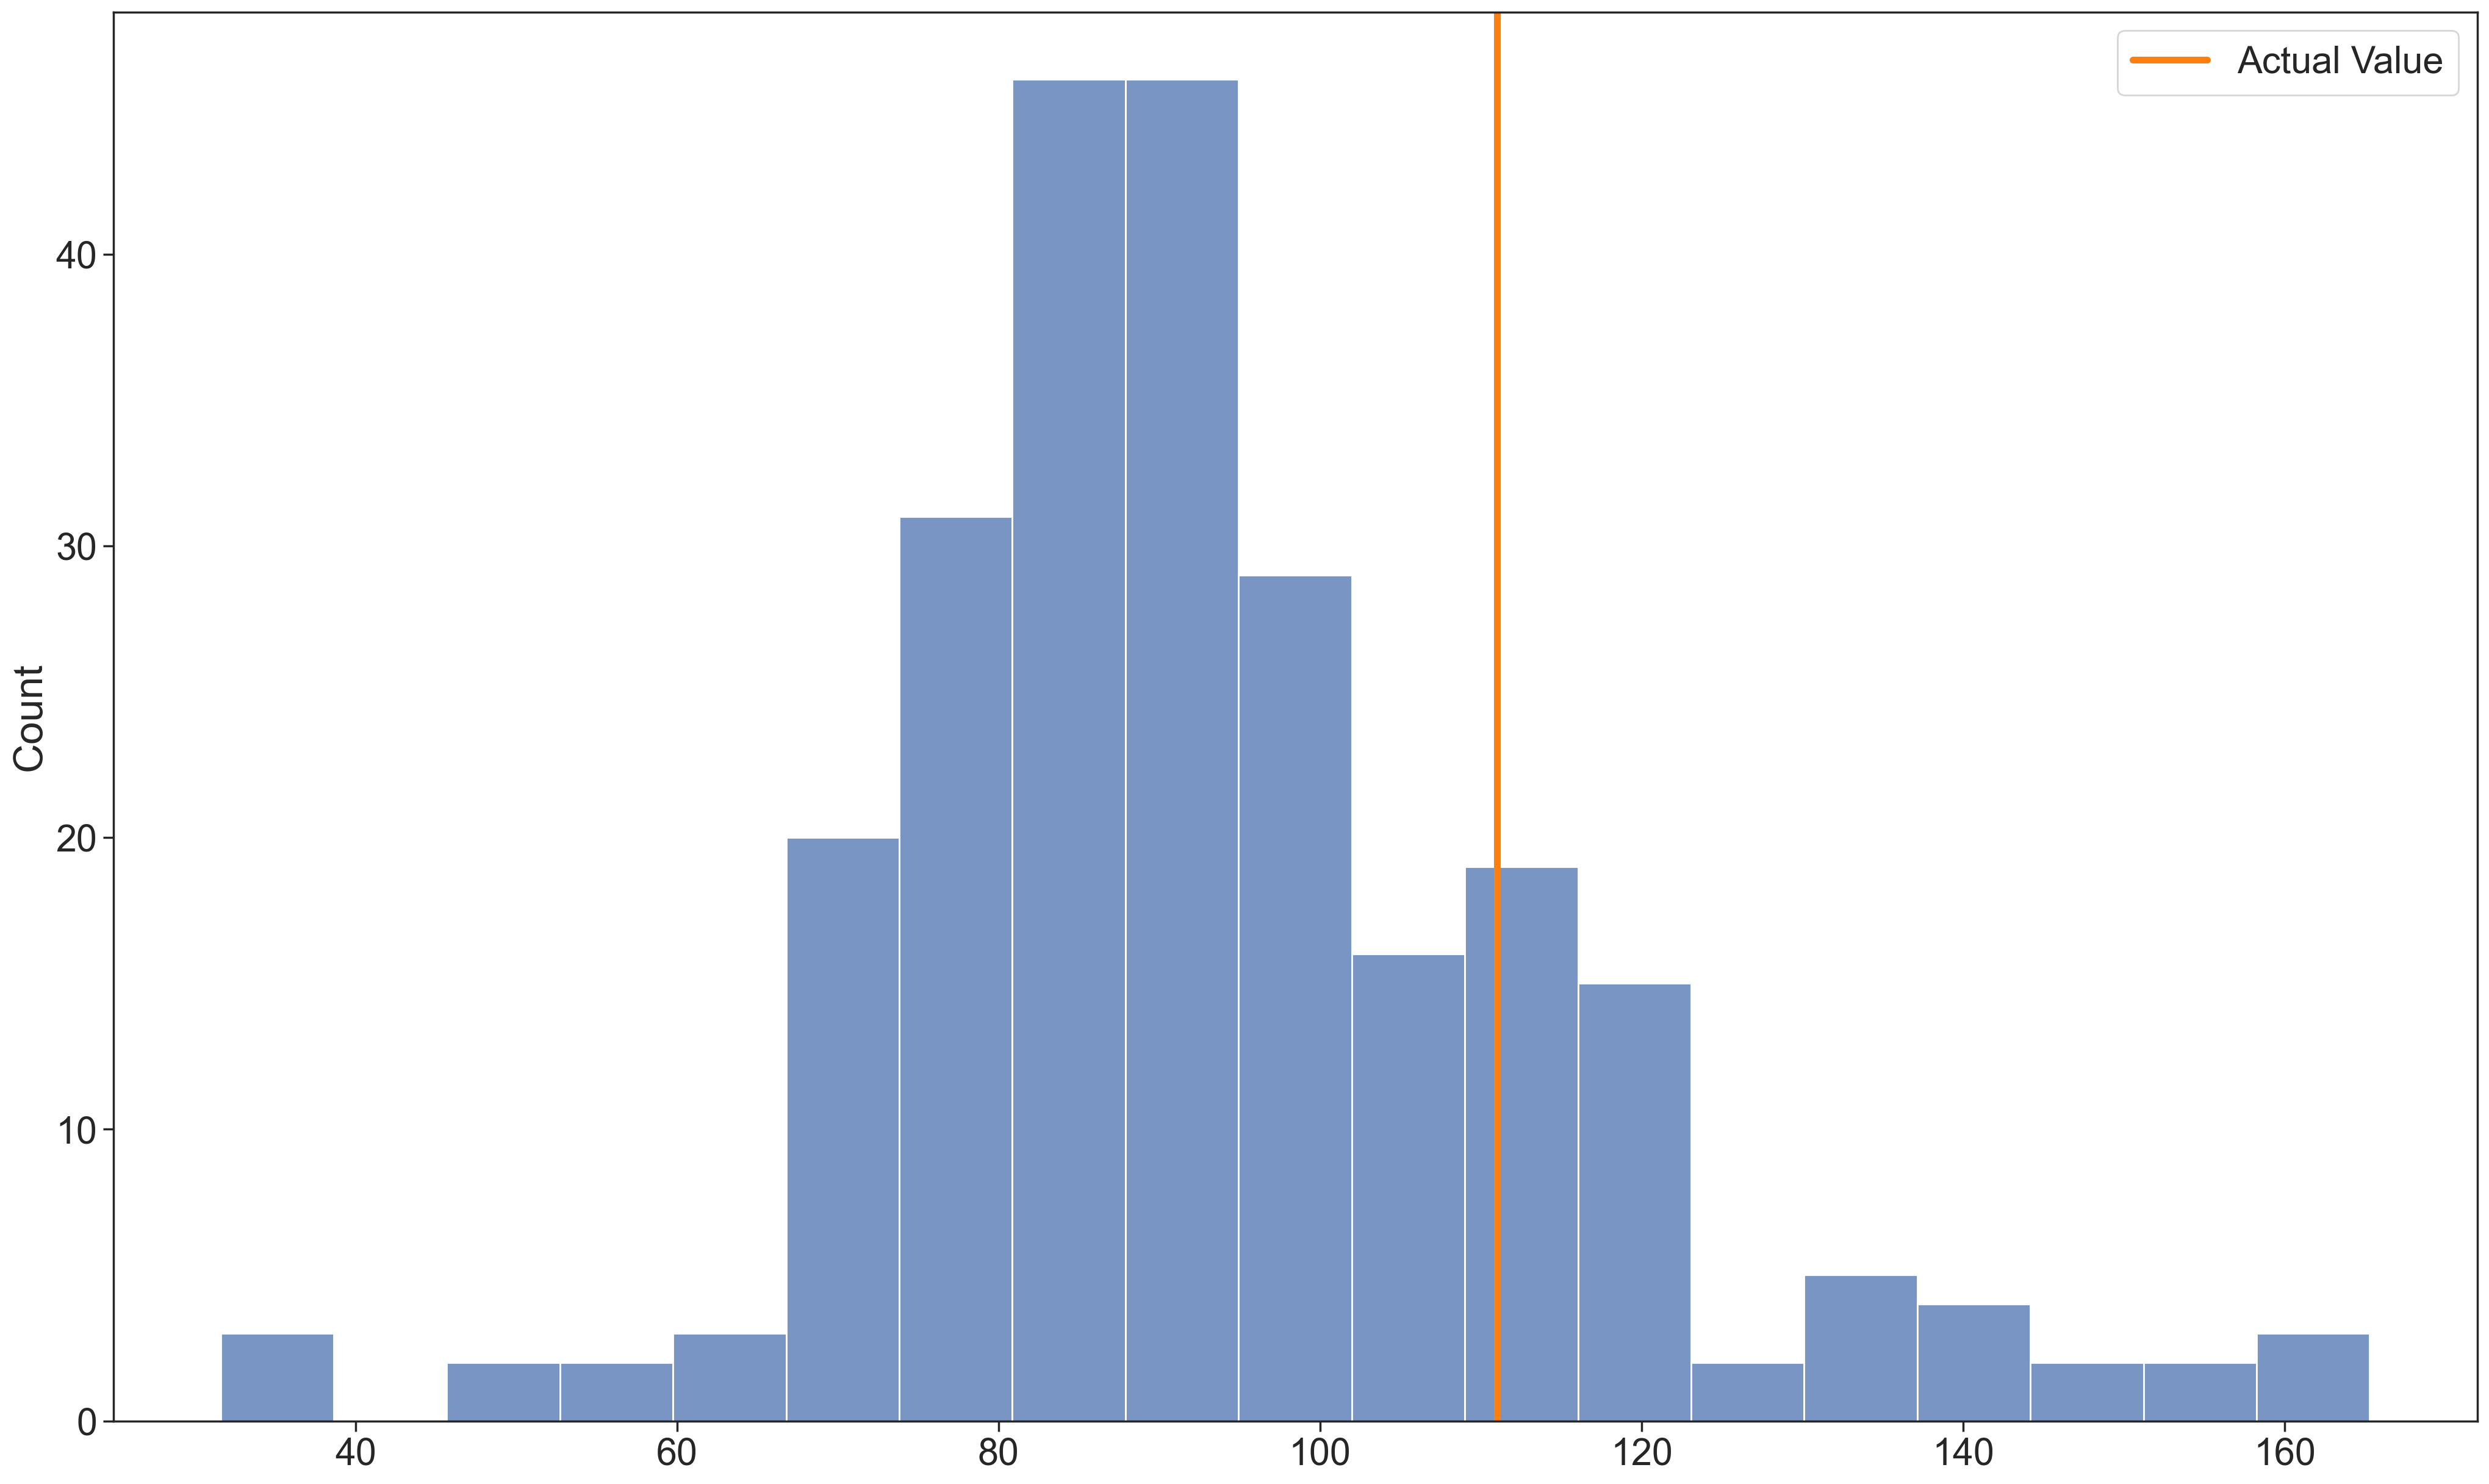

In [15]:
ax = sns.histplot(x=eval_forecasts)
ax.axvline(vegas_df["total_points"][-1], linewidth=4, color="tab:orange", label="Actual Value")
ax.legend()
plt.show()

In [16]:
next_forecasts = bootstrap(vegas_df["total_points"])

In [17]:
np.mean(next_forecasts)

95.47343787342245

In [18]:
np.std(next_forecasts, ddof=1)

15.045677489153721

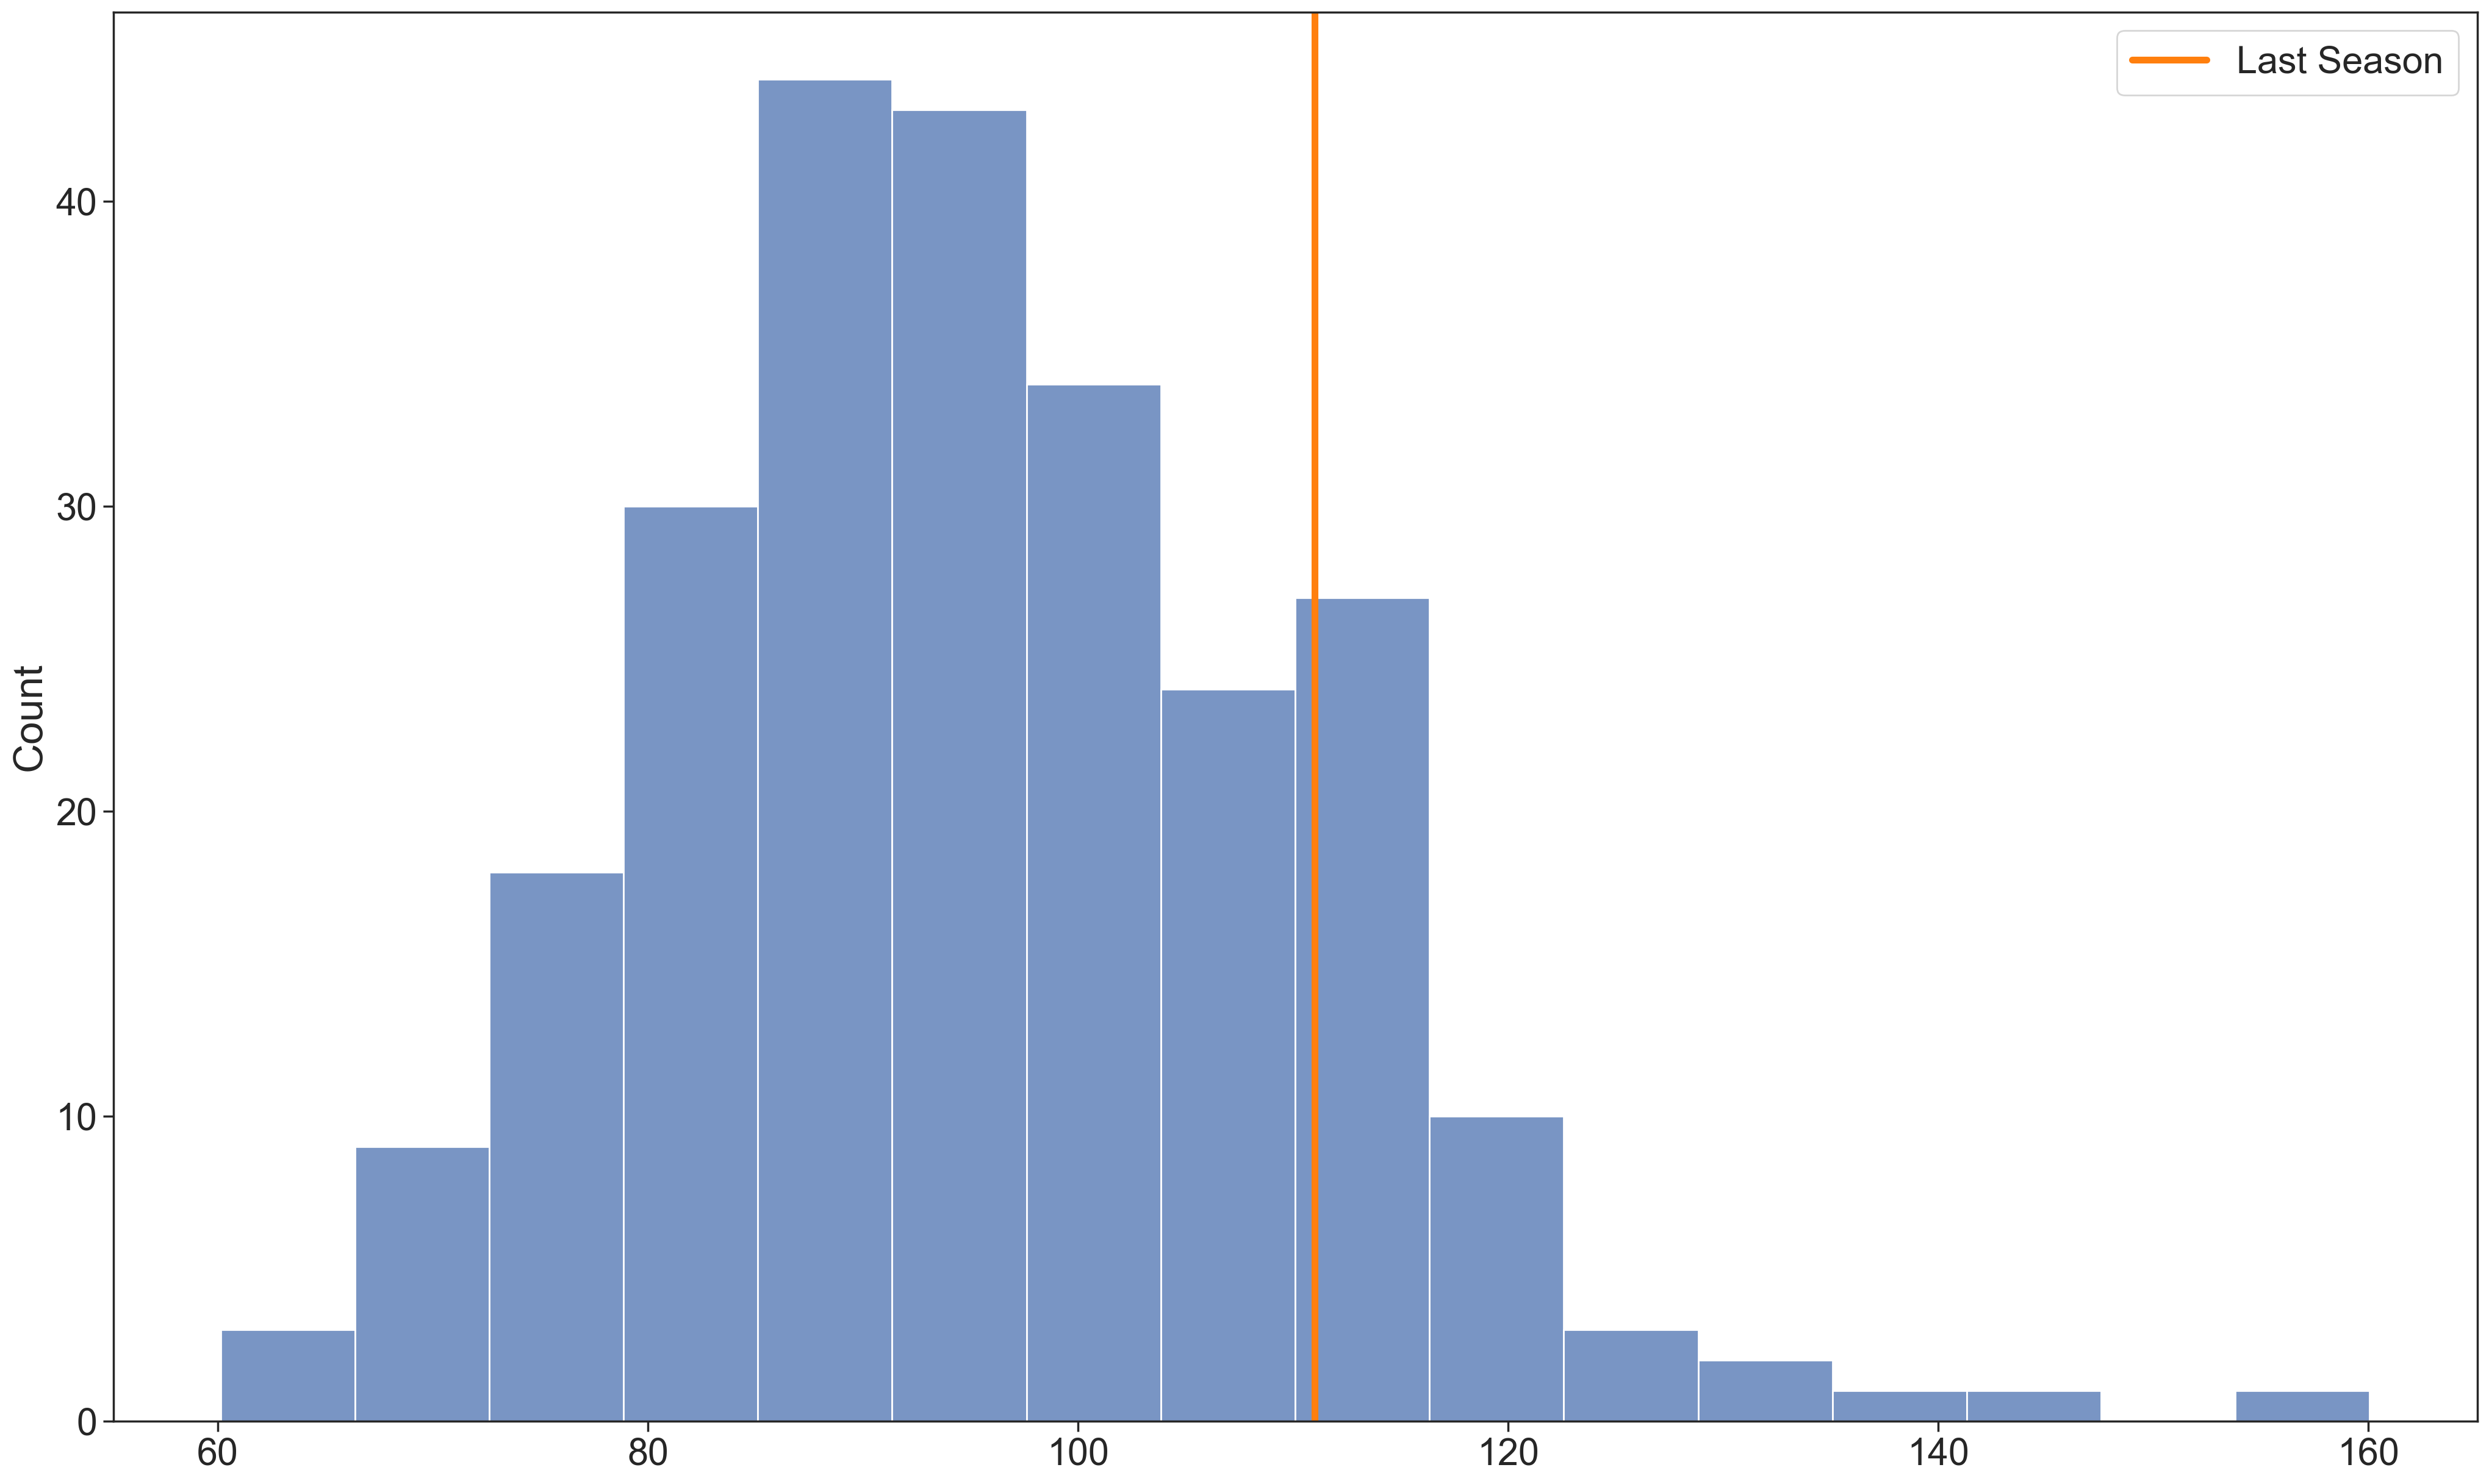

In [19]:
ax = sns.histplot(x=next_forecasts)
ax.axvline(vegas_df["total_points"][-1], linewidth=4, color="tab:orange", label="Last Season")
ax.legend()
plt.show()

In [20]:
interval = 1.96 * np.std(next_forecasts, ddof=1)
(np.mean(next_forecasts) - interval, np.mean(next_forecasts) + interval)

(65.98390999468117, 124.96296575216374)

In [21]:
with open("dianesaysword_predictions_2023-2024.json", 'r') as fh:
    predictions = json.loads(fh.read())

In [22]:
predictions["Predictions"]["VGK"] = (np.around(np.mean(next_forecasts), 1), np.around(interval, 1))

In [23]:
predictions["Predictions"]["VGK"]

(95.5, 29.5)

In [24]:
predictions["Predictions"] = {team : predictions["Predictions"][team]
                              for team in sorted(predictions["Predictions"])}

In [26]:
with open("dianesaysword_predictions_2023-2024.json", 'w') as fh:
    fh.write(json.dumps(predictions, indent=4, ensure_ascii=False))